In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


In [2]:
def get_stock_data(stock_name):
    url = 'http://chart.finance.yahoo.com/table.csv?s=%s&a=11&b=15&c=2011&d=29&e=10&f=2016&g=d&ignore=.csv' % stock_name

    col_names = ['Date','Open','High','Low','Close','Volume','Adj Close']
    stocks = pd.read_csv(url, header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    date_split = df['Date'].str.split('-').str
    df['Year'], df['Month'], df['Day'] = date_split
    df["Volume"] = df["Volume"] / 10000
    df.drop(df.columns[[0,3,5,6,7,8,9]], axis=1, inplace=True) 
    return df

Loading Google from yahoo finance

In [3]:
stock_name = 'GOOGL'
df = get_stock_data(stock_name)
df.head()

,Open,High,Close
0,842.000000,844.000000,835.140015
1,841.390015,841.690002,839.650024
2,849.479980,855.349976,849.799988
3,870.059998,873.469971,850.140015
4,869.479980,870.340027,867.909973


In [4]:
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today
df.to_csv(file_name)

In [5]:
df['High'] = df['High'] / 100
df['Open'] = df['Open'] / 100
df['Close'] = df['Close'] / 100
df.head(5)

,Open,High,Close
0,8.4200,8.4400,8.3514
1,8.4139,8.4169,8.3965
2,8.4948,8.5535,8.4980
3,8.7006,8.7347,8.5014
4,8.6948,8.7034,8.6791


In [6]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    # len(data) = (date - sequence length)
    for index in range(len(data) - sequence_length):
        # result = day0 to (day0 + sequence)
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    # 90% split
    row = round(0.9 * result.shape[0])
    # 90% date, all features
    train = result[:int(row), :]
    # x = all feature except the last column
    x_train = train[:, :-1]
    # y = last day, data[index+sequence_length]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [7]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer="uniform",activation='relu'))        
        model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

Setting X and Y for training and testing

In [8]:
window = 22
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

('X_train', (1173, 22, 3))
('y_train', (1173,))
('X_test', (130, 22, 3))
('y_test', (130,))


In [9]:
model = build_model2([3,window,1])

In [10]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,
    validation_split=0.1,
    verbose=1)

Train on 1055 samples, validate on 118 samples
Epoch 1/500
1055/1055 [==============================] - 4s - loss: 54.5185 - acc: 0.0000e+00 - val_loss: 56.4471 - val_acc: 0.0000e+00
Epoch 2/500
1055/1055 [==============================] - 2s - loss: 54.0741 - acc: 0.0000e+00 - val_loss: 55.9239 - val_acc: 0.0000e+00
Epoch 3/500
1055/1055 [==============================] - 2s - loss: 53.5595 - acc: 0.0000e+00 - val_loss: 55.3086 - val_acc: 0.0000e+00
Epoch 4/500
1055/1055 [==============================] - 2s - loss: 52.9372 - acc: 0.0000e+00 - val_loss: 54.4624 - val_acc: 0.0000e+00

In [11]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.04 MSE (0.21 RMSE)
Test Score: 0.01 MSE (0.10 RMSE)


In [12]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

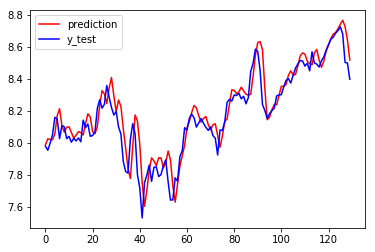

In [13]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()

In [14]:
model.save('my_LSTM_stock_model.h5')